In [77]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from einops import rearrange, repeat
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

In [66]:
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])  #remove last layer

In [67]:
resnet_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [101]:
def preprocess_image(slice_tensor):
    preprocess = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(slice_tensor)
    input_batch = input_tensor.unsqueeze(0)
    
    return input_batch

In [109]:
def extract_features(image_path, model):
    input_batch = preprocess_image(image_path)
    with torch.no_grad():
        model.eval()
        output = model(input_batch)
    features = torch.flatten(output, start_dim=1)
    return features

In [5]:
CT_Vol_DIR = "/Users/sudarshan/darshanz/datasets/lung1/CT_ONLY/vols"
Resnet_Ftrs_DIR = "/Users/sudarshan/darshanz/datasets/lung1/CT_ONLY/resnet"

In [6]:
ct_volume = torch.load(f"{CT_Vol_DIR}/LUNG1-001.pt")

In [7]:
three_channel = repeat(ct_volume, 'slices w h -> slices c w h', c=3)

In [8]:
three_channel.shape

torch.Size([300, 3, 224, 224])

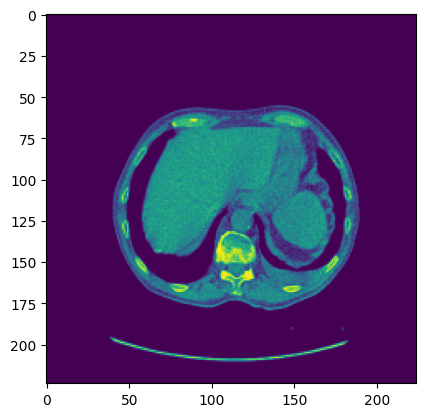

In [89]:
preprocessed_img = preprocess_image(three_channel[100])
plt.imshow(preprocessed_img[0][0])

In [93]:
preprocessed_img.shape

torch.Size([1, 3, 224, 224])

In [90]:
preprocessed_img = preprocessed_img.double()
resnet_model = resnet_model.double()

In [111]:
resnet_ftrs = []
print(three_channel.shape)
count = 0
for slice in three_channel:
    count = count+1
    ftrs = extract_features(slice, resnet_model)
    resnet_ftrs.append(ftrs)
    print(len(resnet_ftrs))
    if count == 4:
        break
print(torch.vstack(resnet_ftrs).shape)

torch.Size([300, 3, 224, 224])
1
2
3
4
torch.Size([4, 2048])


In [114]:
2048*300 > 224 * 224

True

In [ ]:
for subject_ in tqdm(sorted(os.listdir(CT_Vol_DIR))):
    if subject_ not in '.DS_Store':
        ct = torch.load(f'{CT_Vol_DIR}/{subject_}')
        ct_resized = resize_slices(ct)
        torch.save(ct_resized, f'{CT_Vol_DIR}/{subject_}')